Dependencies

In [3]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from sklearn.cluster import MiniBatchKMeans
import random
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, top_k_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from torchsummary import summary

# Prerequisites

Dataset download

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/ifood-2019-fgvc6.zip .

In [4]:
!unzip ifood-2019-fgvc6.zip

Archive:  ifood-2019-fgvc6.zip
  inflating: class_list.txt          
  inflating: ifood2019_sample_submission.csv  
  inflating: sample_submission.csv   
  inflating: test_set.zip            
  inflating: train_labels.csv        
  inflating: train_set.zip           
  inflating: val_labels.csv          
  inflating: val_set.zip             


In [5]:
# Get dictionaries with class names
file_path = '/content/class_list.txt'


class_dict = {}
class_dict_num = {}

with open(file_path, 'r') as file:
    for line in file:
        # Split the line into number and name
        number, name = line.strip().split(maxsplit=1)
        # Add to the dictionary
        class_dict[name] = int(number)
        class_dict_num[int(number)] = name

In [38]:
# get labels, val_labels will be used for the final testing
train_labels = pd.read_csv('/content/train_labels.csv')
test_labels = pd.read_csv('/content/val_labels.csv')

In [7]:
!unzip /content/train_set.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train_set/train_041974.jpg  
  inflating: train_set/train_034206.jpg  
  inflating: train_set/train_054163.jpg  
  inflating: train_set/train_009636.jpg  
  inflating: train_set/train_013213.jpg  
  inflating: train_set/train_077657.jpg  
  inflating: train_set/train_026194.jpg  
  inflating: train_set/train_000231.jpg  
  inflating: train_set/train_060476.jpg  
  inflating: train_set/train_093616.jpg  
  inflating: train_set/train_054918.jpg  
  inflating: train_set/train_025201.jpg  
  inflating: train_set/train_022071.jpg  
  inflating: train_set/train_071302.jpg  
  inflating: train_set/train_035078.jpg  
  inflating: train_set/train_019982.jpg  
  inflating: train_set/train_060417.jpg  
  inflating: train_set/train_081457.jpg  
  inflating: train_set/train_021311.jpg  
  inflating: train_set/train_077393.jpg  
  inflating: train_set/train_102642.jpg  
  inflating: train_set/train_062665.jpg  
  inflat

In [8]:
!unzip /content/val_set.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: val_set/val_006506.jpg  
  inflating: val_set/val_004199.jpg  
  inflating: val_set/val_000848.jpg  
  inflating: val_set/val_007717.jpg  
  inflating: val_set/val_007130.jpg  
  inflating: val_set/val_002708.jpg  
  inflating: val_set/val_001085.jpg  
  inflating: val_set/val_005015.jpg  
  inflating: val_set/val_012038.jpg  
  inflating: val_set/val_010613.jpg  
  inflating: val_set/val_010968.jpg  
  inflating: val_set/val_007924.jpg  
  inflating: val_set/val_010303.jpg  
  inflating: val_set/val_001124.jpg  
  inflating: val_set/val_011892.jpg  
  inflating: val_set/val_006131.jpg  
  inflating: val_set/val_012008.jpg  
  inflating: val_set/val_004498.jpg  
  inflating: val_set/val_008342.jpg  
  inflating: val_set/val_005417.jpg  
  inflating: val_set/val_012107.jpg  
  inflating: val_set/val_002339.jpg  
  inflating: val_set/val_010129.jpg  
  inflating: val_set/val_000308.jpg  
  inflating: val_set

Let's look at the dataset and class distributions

In [ ]:
# display random images from the dataset
random_images = train_labels.sample(n=10)
def load_image_info(img_path):
    image = Image.open(img_path)
    return image, image.size

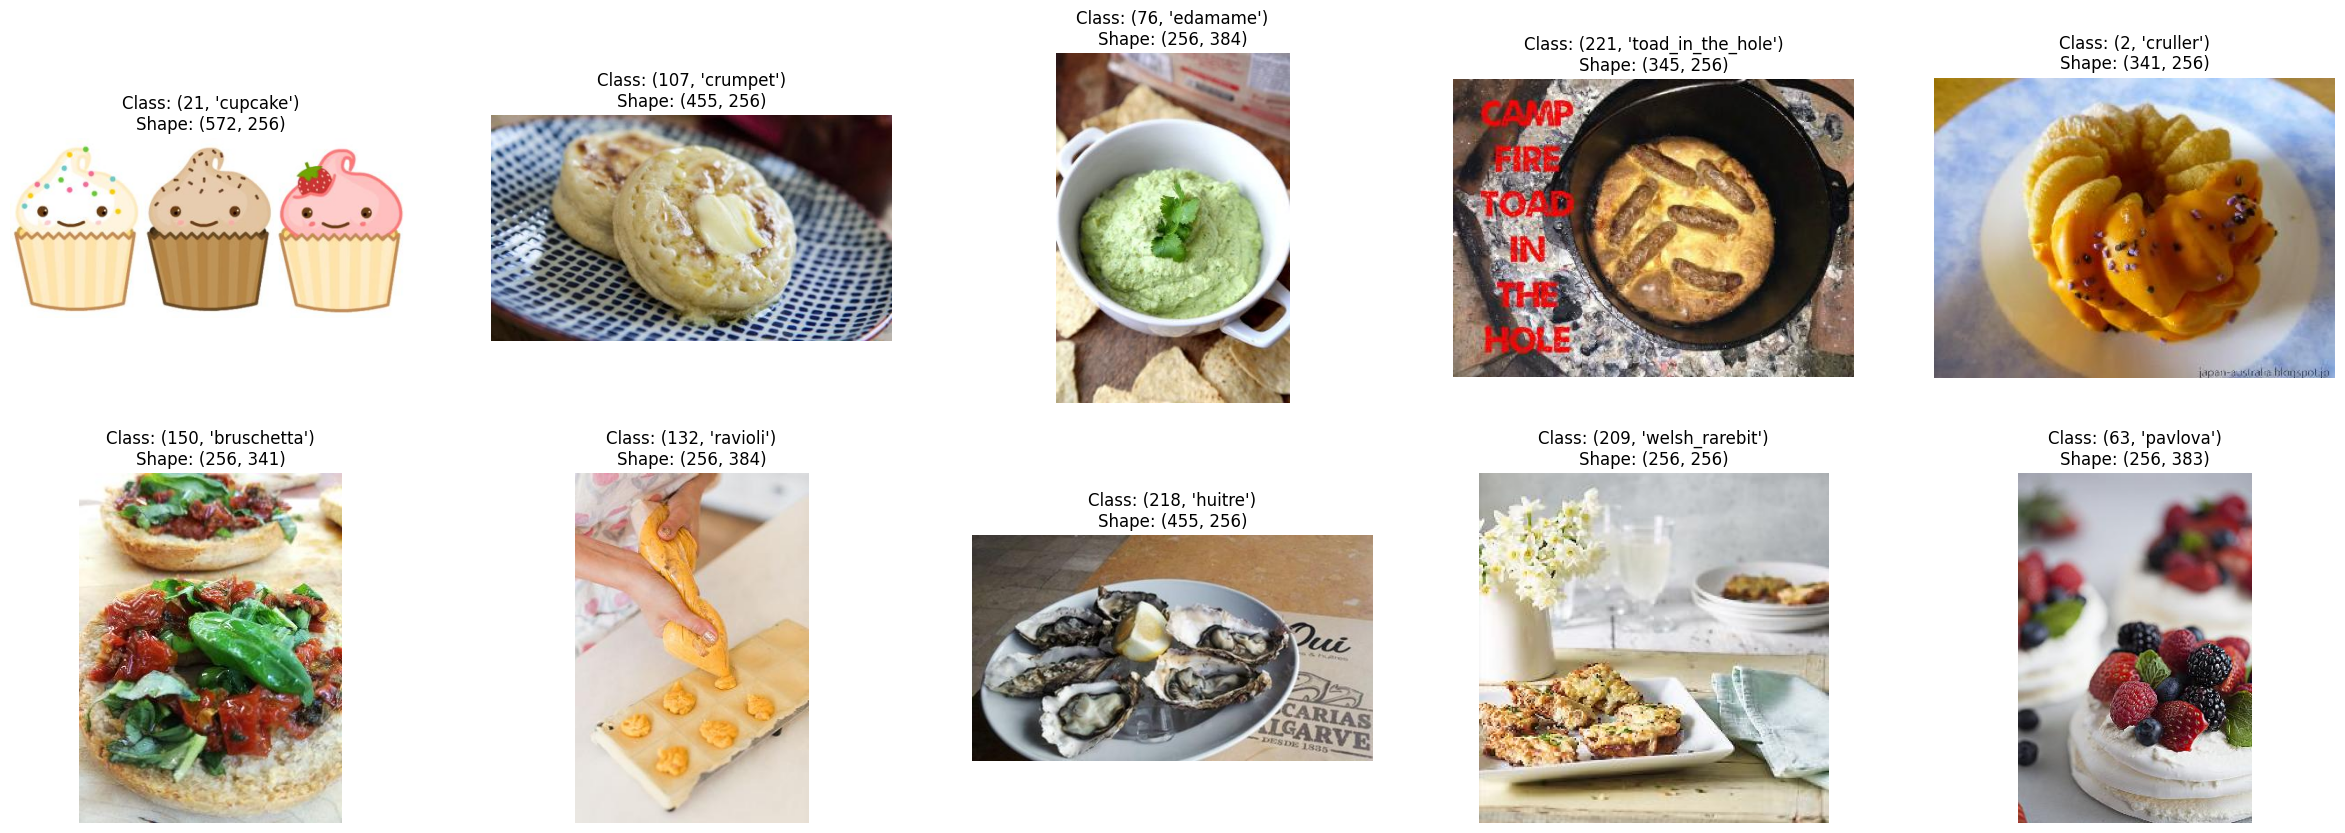

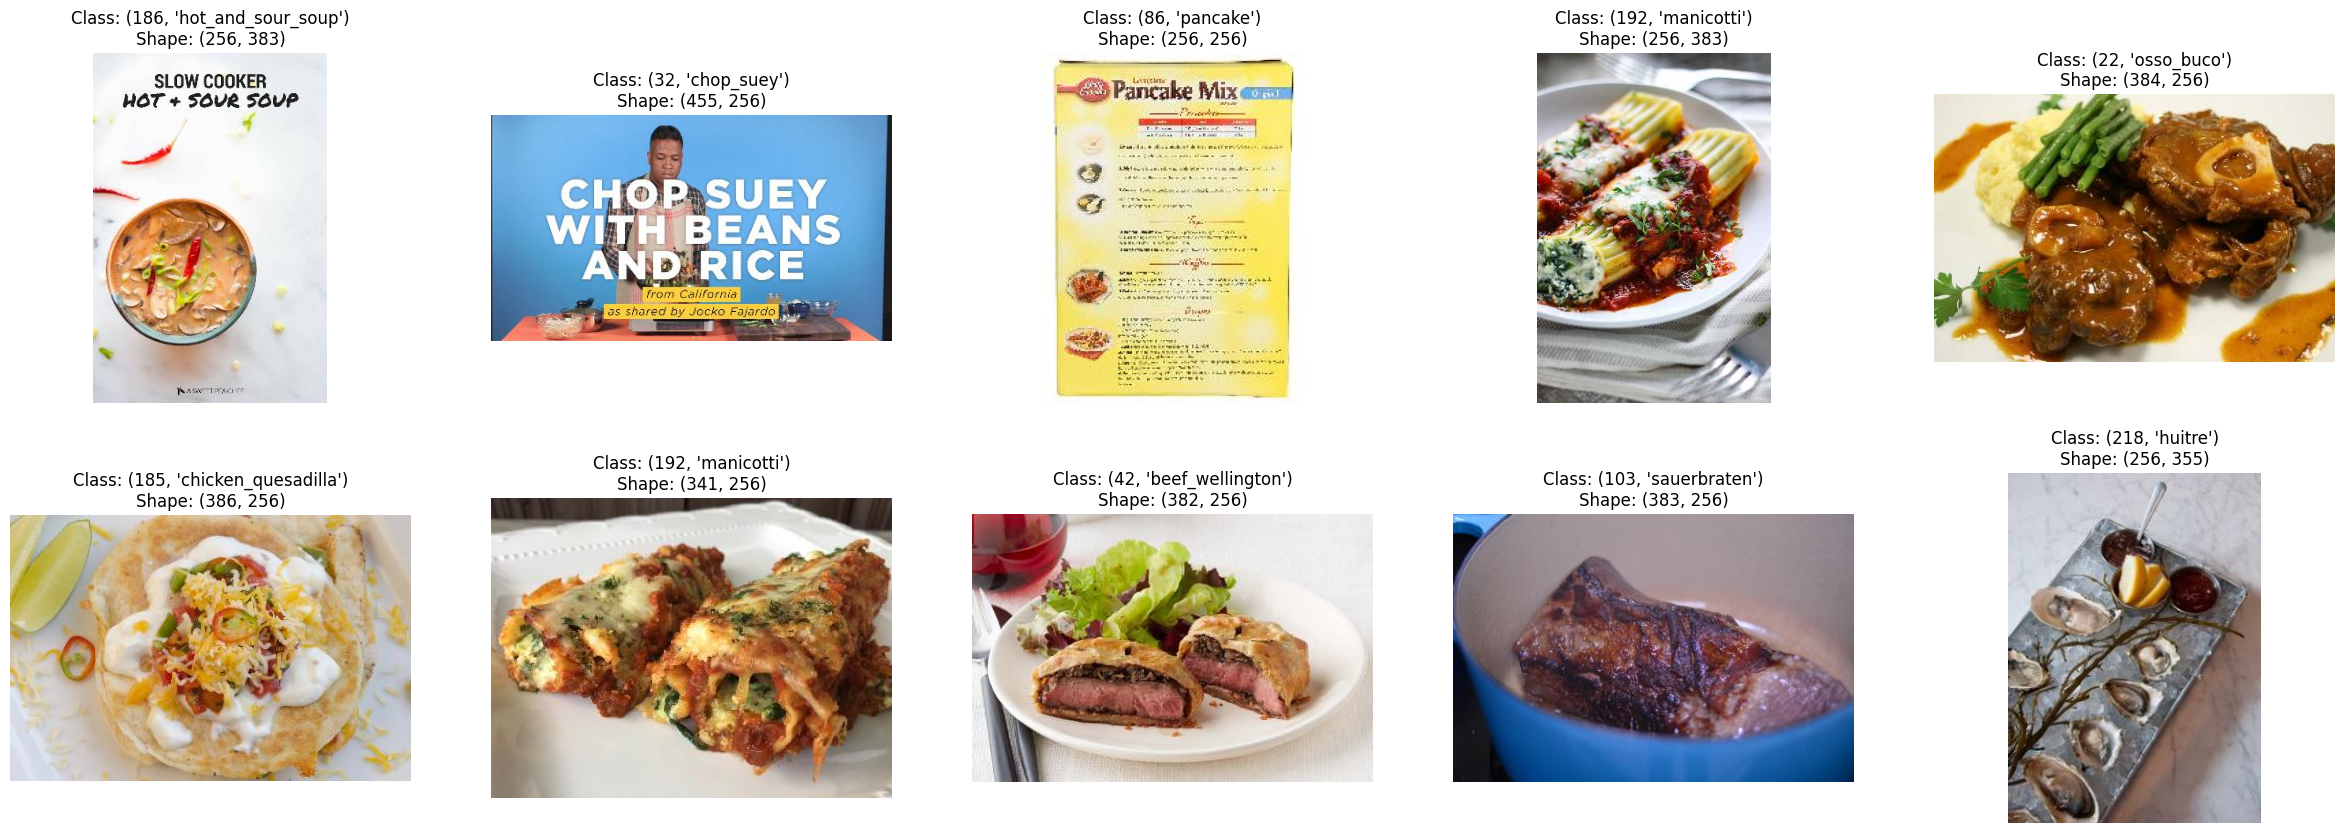

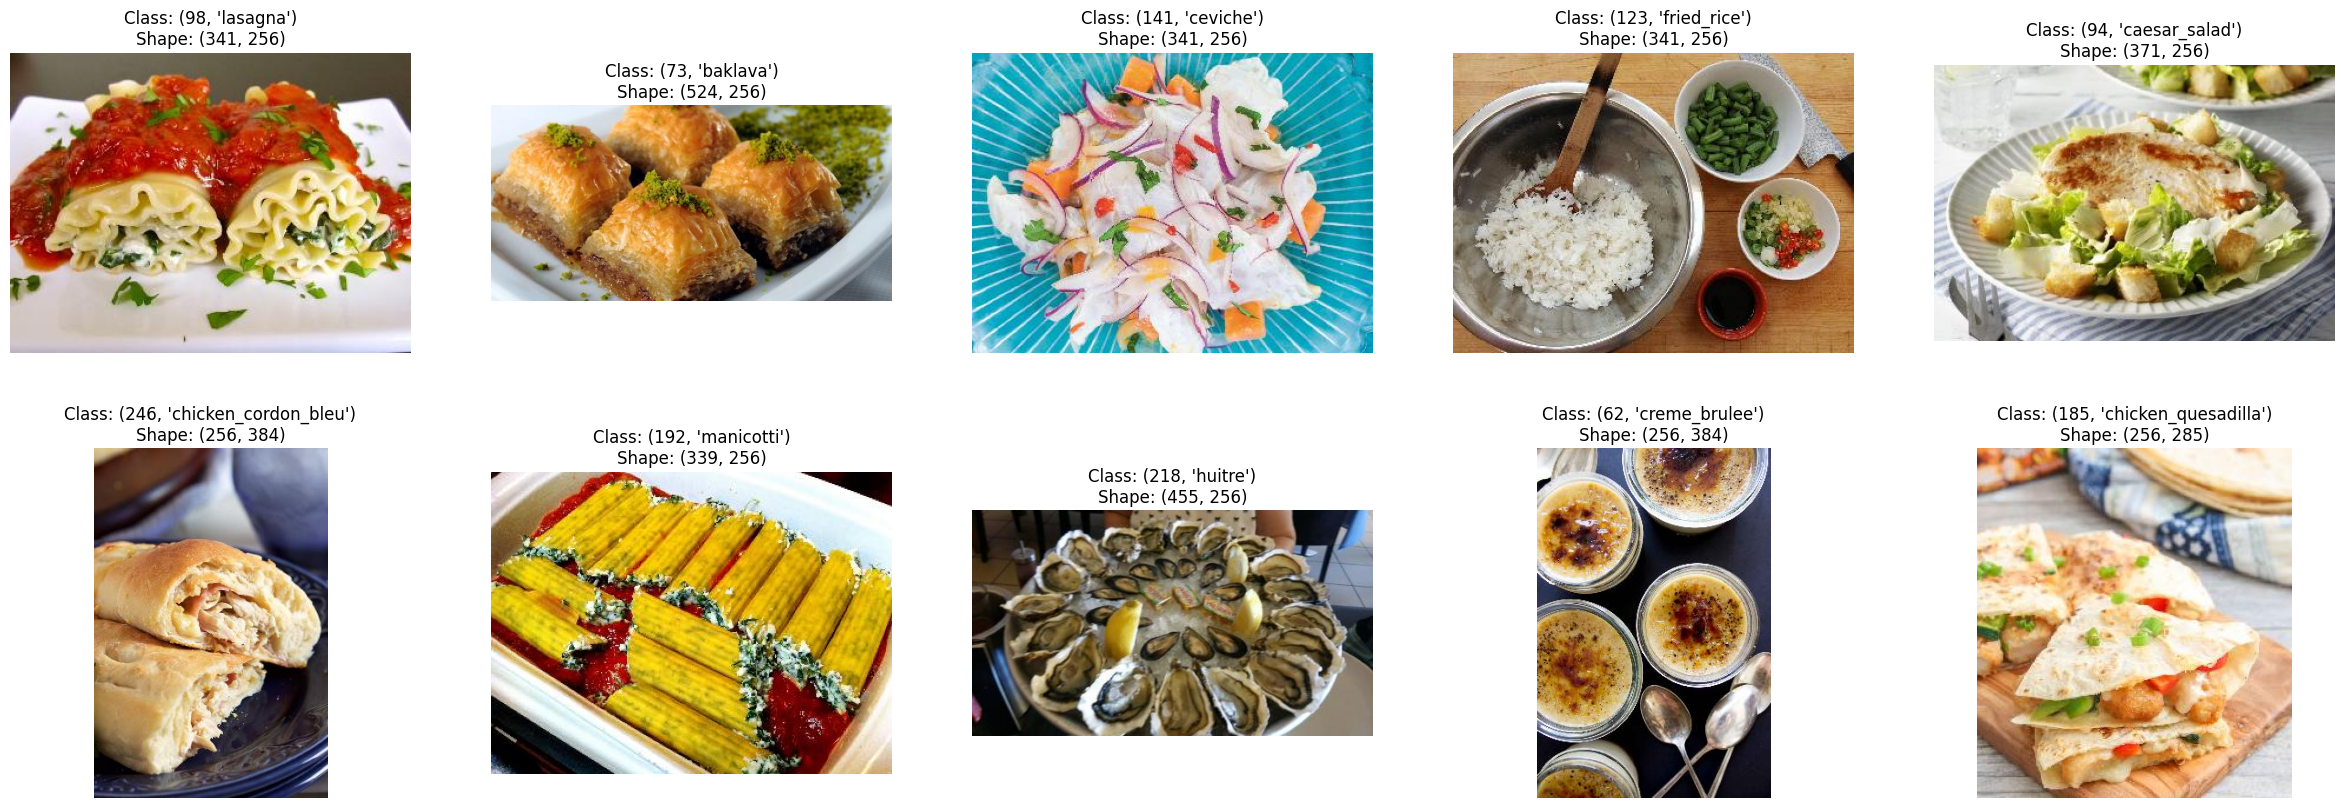

In [ ]:
for j in range(3):
  random_images = train_labels.sample(n=10)
  fig, axs = plt.subplots(2,5, figsize=(30, 10))
  axs = axs.ravel()
  j=0
  for i, row in random_images.iterrows():
    img_name = row['img_name']
    img_class = row['label']
    img_path = os.path.join('/content/train_set', img_name)
    image, img_shape = load_image_info(img_path)
    axs[j].imshow(image)
    axs[j].set_title(f"Class: {img_class, class_dict_num[img_class]}\nShape: {img_shape}")
    axs[j].axis('off')
    j += 1

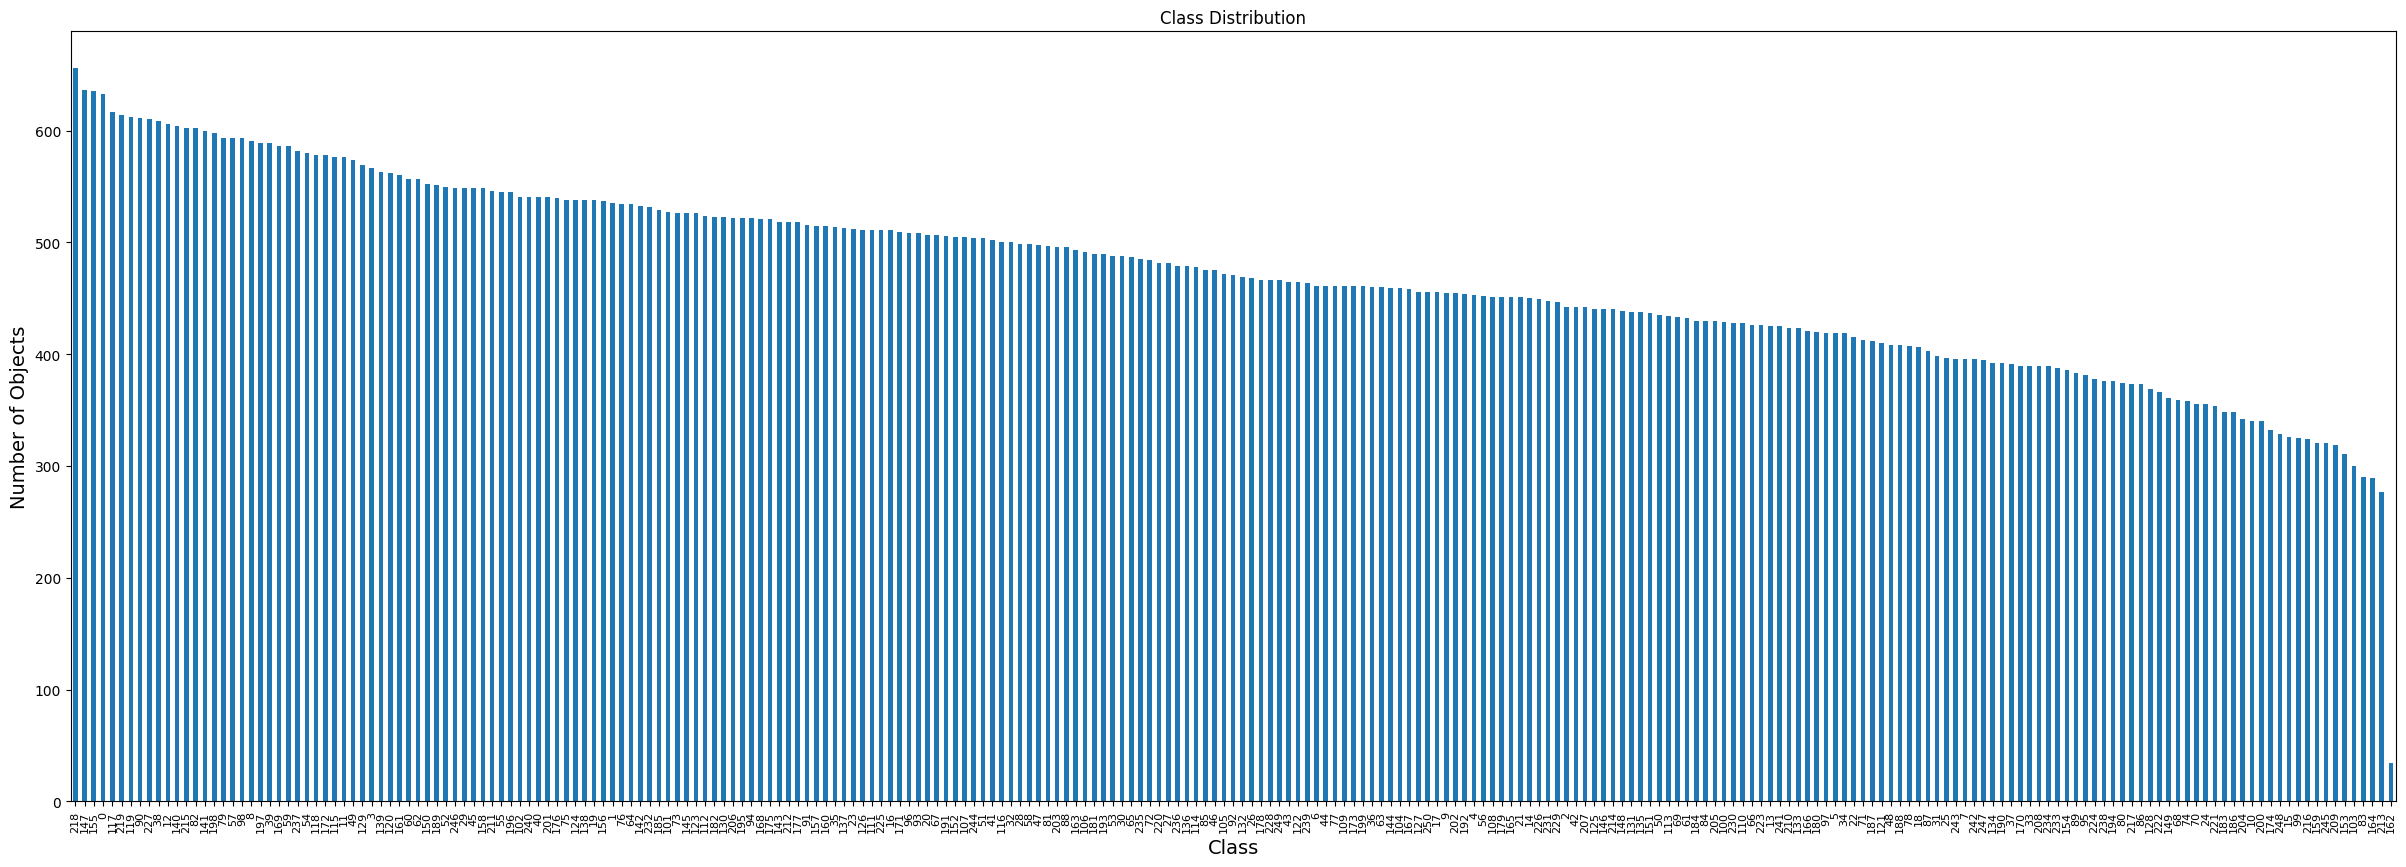

In [ ]:
plt.figure(figsize=(30, 10))
train_labels['label'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Objects', fontsize=14)
plt.xticks(fontsize=8, rotation=90)
plt.show()

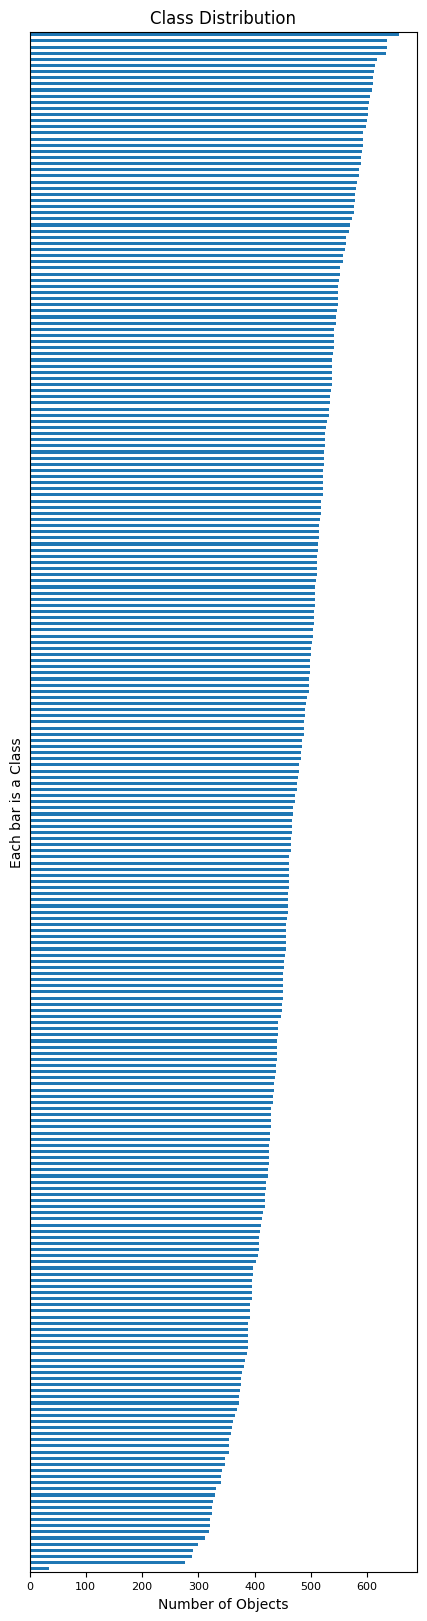

In [42]:
train_labels['label'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(5, 20), fontsize=8)
plt.title('Class Distribution')
plt.xlabel('Number of Objects')
plt.ylabel('Each bar is a Class')
plt.yticks([])
plt.show()

In [ ]:
# here we calculate the average shape of images
def get_image_sizes(image_dir):
    heights = []
    widths = []
    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
    return np.array(widths), np.array(heights)

image_dir = '/content/train_set'
widths, heights = get_image_sizes(image_dir)

print(f"Average width: {np.mean(widths)}")
print(f"Average height: {np.mean(heights)}")

Average width: 341.20814517830763
Average height: 287.1410508546107


In [ ]:
# set random seed
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# CNNs!

In [9]:
# function to evaluate models
def evaluate_model(model, dataloader, device, class_dict_num):
    model.eval()
    true_labels = []
    predictions = []
    probs = []

    # iterate through the data, get predictions
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs.append(outputs.softmax(dim=1).cpu().numpy())  # Softmax probabilities
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
    top5_acc = top_k_accuracy_score(true_labels, np.concatenate(probs, axis=0), k=5)

    # Check for classes with no predictions
    true_labels_set = set(true_labels)
    predicted_labels_set = set(predictions)
    no_prediction_classes = true_labels_set - predicted_labels_set

    if no_prediction_classes:
        print("Classes with no predictions:")
        for cls in no_prediction_classes:
            print(f'Class: {cls} - {class_dict_num[cls]}')

    # Print results
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, Top-5 Accuracy: {top5_acc:.4f}')

    return accuracy, precision, recall, f1, top5_acc

In [10]:
# Define a dataset class and apply tranformations (resizing, normalization)
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Transform with a smaller image size
transform_smaller = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# Load dataset
img_dir = '/content/train_set'
annotations_file = '/content/train_labels.csv'

dataset = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, transform=transform_smaller)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [49]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the input to the first fully connected layer
        self.fc1_input_features = self._get_fc1_input_features()
        self.fc1 = nn.Linear(in_features=self.fc1_input_features, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=251)

        # save some data
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')



    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _get_fc1_input_features(self):
        # Pass a dummy input through the conv and pool layers to get the output size
        with torch.no_grad():
            x = torch.zeros(1, 3, 100, 100)
            x = F.relu(self.conv1(x))
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = F.relu(self.conv2(x))
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = F.relu(self.conv3(x))
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = x.view(1, -1)
        return x.size(1)

# Instantiate the model
model = CustomCNN()
print(model)

CustomCNN(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2304, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=251, bias=True)
)


In [50]:
# Print a summary of the model
summary(model, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 100, 100]             112
            Conv2d-2            [-1, 8, 50, 50]             296
            Conv2d-3           [-1, 16, 25, 25]           1,168
            Linear-4                  [-1, 256]         590,080
            Linear-5                  [-1, 251]          64,507
Total params: 656,163
Trainable params: 656,163
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.54
Params size (MB): 2.50
Estimated Total Size (MB): 3.16
----------------------------------------------------------------


In [68]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'Layer: {name} | Parameters: {param.numel()}')

Layer: conv1.weight | Parameters: 108
Layer: conv1.bias | Parameters: 4
Layer: conv2.weight | Parameters: 288
Layer: conv2.bias | Parameters: 8
Layer: conv3.weight | Parameters: 1152
Layer: conv3.bias | Parameters: 16
Layer: fc1.weight | Parameters: 589824
Layer: fc1.bias | Parameters: 256
Layer: fc2.weight | Parameters: 64256
Layer: fc2.bias | Parameters: 251


In [69]:
# calculate number of parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

656163

In [70]:
model.fc1_input_features

2304

In [ ]:
# training loop
num_epochs = 30
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

best_val_loss = float('inf')
patience = 5
patience_counter = 0



# Training loop
for epoch in range(num_epochs):
  # Set the model to training mode
    model.train()
    running_loss = 0.0
    loss_for_av = 0.0
    # iterate through the batches
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_for_av += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    avg_train_loss = loss_for_av / len(train_loader)
    model.train_losses.append(avg_train_loss)


    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    model.val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

    # Check for early stopping
    if avg_val_loss < model.best_val_loss:
        model.best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_simple_Cnn.pth')  # Save the best model
    else:
        patience_counter += 1


    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

In [73]:
np.save('/content/drive/My Drive/train_losses_easy.npy', np.array(model.train_losses))
np.save('/content/drive/My Drive/val_losses_easy.npy', np.array(model.val_losses))

# Save the best model
torch.save(model.state_dict(), '/content/drive/My Drive/best_model_easy.pth')

In [21]:
model.state_dict = torch.load('/content/drive/My Drive/best_model_easy.pth', map_location=torch.device('cpu'))

In [25]:
# define dataloaders for validation
test_img_dir = '/content/val_set'
test_annotations_file = '/content/val_labels.csv'
test_dataset = ImageDataset(annotations_file=test_annotations_file, img_dir=test_img_dir, transform=transform_smaller)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [26]:
# Evaluate on the training set
train_accuracy, train_precision, train_recall, train_f1, train_top5_acc = evaluate_model(model, train_loader, device, class_dict_num)
print(f'Training Set - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1:.4f}, Top-5 Accuracy: {train_top5_acc:.4f}')

# Evaluate on the validation set
val_accuracy, val_precision, val_recall, val_f1, val_top5_acc = evaluate_model(model, val_loader, device, class_dict_num)
print(f'Validation Set - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}, Top-5 Accuracy: {val_top5_acc:.4f}')

# Evaluate on the test set
test_accuracy, test_precision, test_recall, test_f1, test_top5_acc = evaluate_model(model, test_loader, device, class_dict_num)
print(f'Test Set - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}, Top-5 Accuracy: {test_top5_acc:.4f}')

Classes with no predictions:
Class: 0 - macaron
Class: 1 - beignet
Class: 2 - cruller
Class: 3 - cockle_food
Class: 4 - samosa
Class: 6 - tostada
Class: 8 - dumpling
Class: 9 - sashimi
Class: 10 - knish
Class: 11 - croquette
Class: 12 - couscous
Class: 13 - porridge
Class: 14 - stuffed_cabbage
Class: 15 - seaweed_salad
Class: 16 - chow_mein
Class: 17 - rigatoni
Class: 18 - beef_tartare
Class: 19 - cannoli
Class: 20 - foie_gras
Class: 21 - cupcake
Class: 22 - osso_buco
Class: 23 - pad_thai
Class: 24 - poutine
Class: 25 - ramen
Class: 26 - pulled_pork_sandwich
Class: 27 - bibimbap
Class: 28 - chicken_kiev
Class: 29 - apple_pie
Class: 30 - risotto
Class: 31 - fruitcake
Class: 32 - chop_suey
Class: 34 - scrambled_eggs
Class: 35 - frittata
Class: 36 - scampi
Class: 37 - sushi
Class: 39 - fritter
Class: 40 - nacho
Class: 41 - beef_stroganoff
Class: 42 - beef_wellington
Class: 43 - spring_roll
Class: 44 - savarin
Class: 45 - crayfish_food
Class: 46 - souffle
Class: 47 - adobo
Class: 48 - stre

In [4]:
# Define new CNN Model
class EnhancedComplexCNN(nn.Module):
    def __init__(self):
        super(EnhancedComplexCNN, self).__init__()
        # Conv layers with batch normalization and dropout
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)


        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.25)


        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.25)


        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.25)

        # Fifth Convolutional Block with Depthwise Separable Convolutions
        self.depthwise_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, groups=256)
        self.pointwise_conv = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout(0.5)

        # Global Average Pooling and Fully Connected Layers
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features=512, out_features=512)
        self.dropout6 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=512, out_features=251)

        # save some data
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.dropout2(x)


        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.dropout3(x)


        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.dropout4(x)


        x = F.relu(self.bn5(self.pointwise_conv(self.depthwise_conv(x))))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.dropout5(x)


        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout6(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = EnhancedComplexCNN()
print(model)

EnhancedComplexCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.25, inplace=False)
  (depthwise_conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
  (pointwise_conv): Conv2d(256, 

In [28]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'Layer: {name} | Parameters: {param.numel()}')

Layer: conv1.weight | Parameters: 864
Layer: conv1.bias | Parameters: 32
Layer: bn1.weight | Parameters: 32
Layer: bn1.bias | Parameters: 32
Layer: conv2.weight | Parameters: 18432
Layer: conv2.bias | Parameters: 64
Layer: bn2.weight | Parameters: 64
Layer: bn2.bias | Parameters: 64
Layer: conv3.weight | Parameters: 73728
Layer: conv3.bias | Parameters: 128
Layer: bn3.weight | Parameters: 128
Layer: bn3.bias | Parameters: 128
Layer: conv4.weight | Parameters: 294912
Layer: conv4.bias | Parameters: 256
Layer: bn4.weight | Parameters: 256
Layer: bn4.bias | Parameters: 256
Layer: depthwise_conv.weight | Parameters: 2304
Layer: depthwise_conv.bias | Parameters: 256
Layer: pointwise_conv.weight | Parameters: 131072
Layer: pointwise_conv.bias | Parameters: 512
Layer: bn5.weight | Parameters: 512
Layer: bn5.bias | Parameters: 512
Layer: fc1.weight | Parameters: 262144
Layer: fc1.bias | Parameters: 512
Layer: fc2.weight | Parameters: 128512
Layer: fc2.bias | Parameters: 251


In [29]:
# calculate number of parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

915963

In [5]:
# Print a summary of the model
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
       BatchNorm2d-2         [-1, 32, 200, 200]              64
           Dropout-3         [-1, 32, 100, 100]               0
            Conv2d-4         [-1, 64, 100, 100]          18,496
       BatchNorm2d-5         [-1, 64, 100, 100]             128
           Dropout-6           [-1, 64, 50, 50]               0
            Conv2d-7          [-1, 128, 50, 50]          73,856
       BatchNorm2d-8          [-1, 128, 50, 50]             256
           Dropout-9          [-1, 128, 25, 25]               0
           Conv2d-10          [-1, 256, 25, 25]         295,168
      BatchNorm2d-11          [-1, 256, 25, 25]             512
          Dropout-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]           2,560
           Conv2d-14          [-1, 512,

In [ ]:
# Training loop (the same as for the simple CNN)
num_epochs = 30
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 5
patience_counter = 0



# Training loop
for epoch in range(num_epochs):
  # Set the model to training mode
    model.train()
    running_loss = 0.0
    loss_for_av = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_for_av += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

    avg_train_loss = loss_for_av / len(train_loader)
    train_losses.append(avg_train_loss)


    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

# Save the training and validation losses for future plotting
np.save('train_losses.npy', np.array(train_losses))
np.save('val_losses.npy', np.array(val_losses))

In [ ]:
np.save('/content/drive/My Drive/train_losses.npy', np.array(train_losses))
np.save('/content/drive/My Drive/val_losses.npy', np.array(val_losses))

# Save the best model
torch.save(model.state_dict(), '/content/drive/My Drive/best_model.pth')

In [32]:
model.load_state_dict(torch.load('/content/best_model (1).pth', map_location=torch.device('cpu')))
model.val_losses = np.load('/content/val_losses.npy')
model.train_losses = np.load('/content/train_losses.npy')
model.best_val_loss = np.load('/content/best_val_loss.npy')

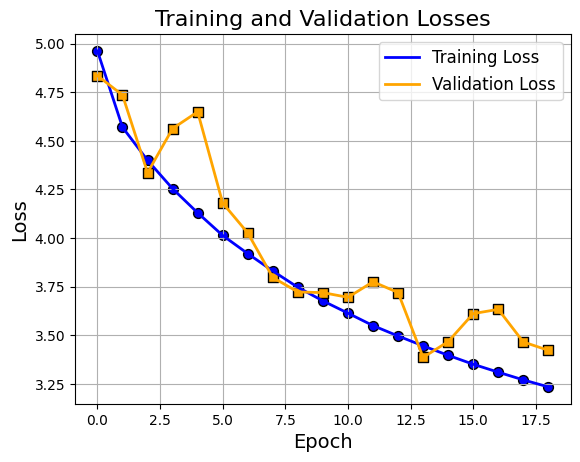

In [33]:
# Plot training loss
plt.plot(model.train_losses, label='Training Loss', color='blue', linewidth=2)
plt.scatter(range(len(model.train_losses)), model.train_losses, color='blue', marker='o', s=50, edgecolor='k')

# Plot validation loss
plt.plot(model.val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.scatter(range(len(model.val_losses)), model.val_losses, color='orange', marker='s', s=50, edgecolor='k')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Losses', fontsize=16)
plt.grid(True)

plt.legend(loc='best', fontsize=12)

plt.show()

In [ ]:
# Get the data loaders for the evaluation
# Load dataset
img_dir = '/kaggle/working/train_set'
annotations_file = '/kaggle/input/ifood-2019-fgvc6/train_labels.csv'

dataset = ImageDataset(annotations_file=annotations_file, img_dir=img_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [34]:
test_img_dir = '/content/val_set'
test_annotations_file = '/content/val_labels.csv'
test_dataset = ImageDataset(annotations_file=test_annotations_file, img_dir=test_img_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

EnhancedComplexCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.25, inplace=False)
  (depthwise_conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
  (pointwise_conv): Conv2d(256, 

In [36]:
# Evaluate on the test set
test_accuracy, test_precision, test_recall, test_f1, test_top5_acc = evaluate_model(model, test_loader, device, class_dict_num)
print(f'Test Set - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}, Top-5 Accuracy: {test_top5_acc:.4f}')

Classes with no predictions:
Class: 65 - scallop
Class: 243 - mostaccioli
Class: 238 - rugulah
Accuracy: 0.2908, Precision: 0.3197, Recall: 0.2908, F1-score: 0.2696, Top-5 Accuracy: 0.5785
Test Set - Accuracy: 0.2908, Precision: 0.3197, Recall: 0.2908, F1-score: 0.2696, Top-5 Accuracy: 0.5785
